### This notebook uses traditional ML unsupervised clustering approaches to obtain activity-related response groups

In [1]:
import sys, os
DMOL_DIR = "../"
sys.path.append(os.path.join(DMOL_DIR, "utils"))

from ml_utils import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering

In [2]:
def get_bag_of_words(text, tf_idf = False, params = None):
    vectorizer = CountVectorizer(**params) if not tf_idf else TfidfVectorizer(**params)
    corpus = vectorizer.fit_transform(text)
    return vectorizer, corpus
    
def fit_clustering_methods(corpus, params, kMeans = True):
    classifier = KMeans(**params) if kMeans else AgglomerativeClustering(**params)
    labels = classifier.fit_predict(corpus.toarray())
    return classifier, labels

def visualize_cluster_bag_words(num_cluster, corpus, labels, vectorizer, recursive_group = 0):
    for i in range(num_cluster):
        print("Group {}-{}".format(recursive_group, i+1))
        label_corpus = corpus[np.where(labels == i)]
        print("Size:  ", label_corpus.shape[0])
        try:
            generate_wordcloud(" ".join(np.char.join(' ', vectorizer.inverse_transform(corpus[np.where(labels == i)]))))
        except TypeError as e:
            generate_wordcloud(" ".join([i[0] for i in np.char.join('', vectorizer.inverse_transform(corpus[np.where(labels == i)]))
                                        if len(i) >= 1])) 
            
def plot_cluster_bag_words(num_cluster, corpus, labels, vectorizer, recursive_group = 0, nrow = 2, ncol = 2, fname = None):
    fig, axes = plt.subplots(nrow, ncol, figsize=(13.8,6), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        
        print("Group {}-{}".format(recursive_group, i+1))
        label_corpus = corpus[np.where(labels == i)]
        print("Size:  ", label_corpus.shape[0])
        try:
            text = " ".join(np.char.join(' ', vectorizer.inverse_transform(corpus[np.where(labels == i)])))
        except TypeError as e:
            text = " ".join([i[0] for i in np.char.join('', vectorizer.inverse_transform(corpus[np.where(labels == i)]))
                                        if len(i) >= 1]) 
        text_to_generate = text   
        if type(text) == list:
            text_to_generate = " ".join([" ".join(i) for i in text]) if type(text[0]) == list else " ".join(text)
        wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white', color_func=lambda *args, **kwargs: '#000000', 
                              collocations = False).generate(text_to_generate)
              
        plt.gca().imshow(wordcloud, interpolation = 'bilinear')
        plt.gca().set_title('Cluster ' + str(i+1), fontdict=dict(size=22))
        plt.gca().axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    if fname is not None:
        plt.savefig(fname, format='eps', dpi=1200)
    plt.show()
    
    
def unsupervised_checking(text_array, tf_idf = False, kMeans = True, recursive = False, recursive_group = 0,
                          vectorizer_params = None, clustering_params = None, nrow=2, ncol=2, fname = None):
    num_cluster = clustering_params["n_clusters"]
    vectorizer, corpus = get_bag_of_words(text_array, tf_idf = tf_idf, params = vectorizer_params)
    classifier, labels = fit_clustering_methods(corpus, clustering_params, kMeans = kMeans)
#     visualize_cluster_bag_words(num_cluster, corpus, labels, vectorizer, recursive_group = recursive_group)
    plot_cluster_bag_words(num_cluster, corpus, labels, vectorizer, recursive_group = recursive_group, nrow=nrow, ncol=ncol, fname = fname)

    group_size = sorted([(i, corpus[np.where(labels == i)].shape[0]) for i in range(num_cluster)], 
                         key = lambda x: x[1], reverse = True)
    if group_size[0][1] > 2 * group_size[1][1] and recursive:
        recursive_group += 1
        print('\nRecursive on group {}\n'.format(group_size[0][0] + 1))
        _ = unsupervised_checking([text_array[i] for i in np.where(labels == group_size[0][0])[0]], 
                                  tf_idf = tf_idf, kMeans = KMeans, recursive = recursive, recursive_group = recursive_group,
                                  vectorizer_params = vectorizer_params, clustering_params = clustering_params)
    return classifier, vectorizer
                                       

In [3]:
df = pd.read_csv("../data/open_ended_responses.csv")
assert(os.path.exists("../slides_dataviz/plots/"))

# Other activities

In [4]:
oact_col_names = [c for c in df.columns if "oact" in c and "compx" not in c]
oact = [act for c in oact_col_names for act in df[df[c].notnull()].loc[1:, c]]
preprocessed_oact = [nlp_preprocess(act, use_stemmer=True) for act in oact]

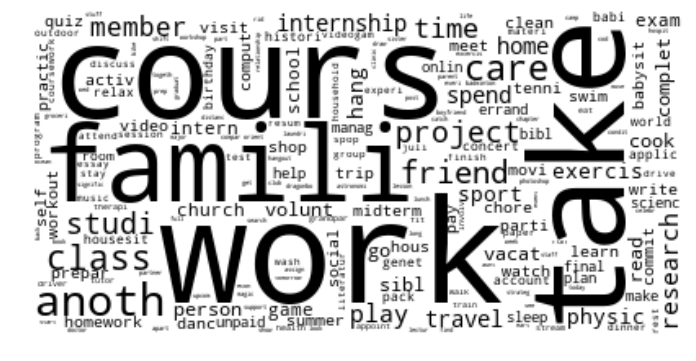

In [5]:
generate_wordcloud(preprocessed_oact, "../slides_dataviz/plots/oact_word_cloud.eps")

Group 0-1
Size:   1525
Group 0-2
Size:   265
Group 0-3
Size:   217
Group 0-4
Size:   286


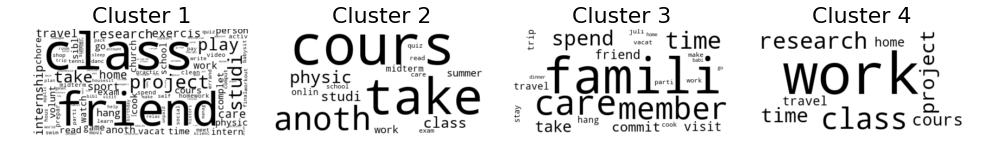

In [6]:
vectorizer_params = {"min_df": 5, "max_df": 500, "lowercase": True, "stop_words": STOPWORDS, "ngram_range": (1, 1)}
clustering_params = {"n_clusters": 4, "random_state": 1}
classifier_oact_kmeans, vectorizer_oact_kmeans = unsupervised_checking(preprocessed_oact, tf_idf = True, kMeans = True,
                                   vectorizer_params = vectorizer_params, clustering_params = clustering_params, nrow=1, ncol=4,
                                    fname = "../slides_dataviz/plots/KMeans_oact_4_clusters.eps")

Group 0-1
Size:   1618
Group 0-2
Size:   180
Group 0-3
Size:   230
Group 0-4
Size:   265


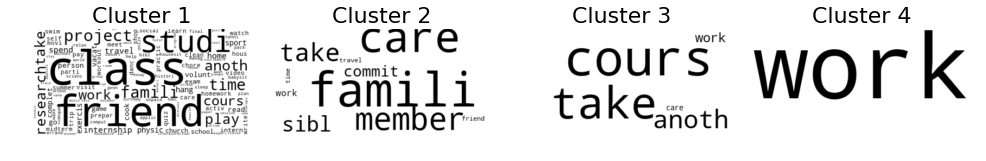

In [7]:
clustering_params = {"n_clusters": 4}
classifier_oact_agg, vectorizer_oact_agg = unsupervised_checking(preprocessed_oact, tf_idf =True, kMeans = False,
                      vectorizer_params = vectorizer_params, clustering_params = clustering_params,nrow=1, ncol=4,
                      fname = "../slides_dataviz/plots/AGG_oact_4_clusters.eps")

## Other activities could be separated into "Personal (family)", "another Class", "Work", "Leisure"

# Course-related activities

In [8]:
cact_col_names = ["dcact{}".format(i) for i in range(1, 31)]
cact = [act for c in cact_col_names for act in df[df[c].notnull()].loc[1:, c]]
preprocessed_cact = [nlp_preprocess(act) for act in cact]

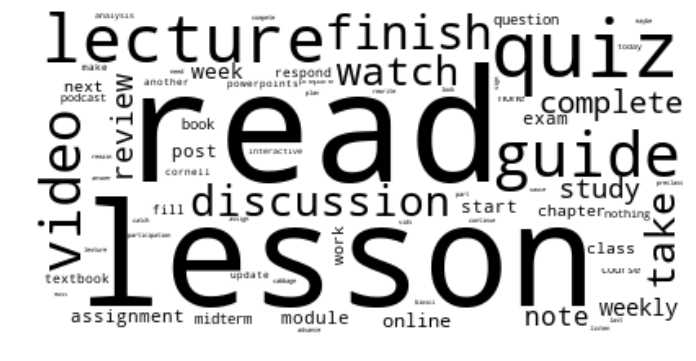

In [9]:
generate_wordcloud(preprocessed_cact, "../slides_dataviz/plots/cact_wordcloud.eps")

Group 0-1
Size:   156
Group 0-2
Size:   454
Group 0-3
Size:   195


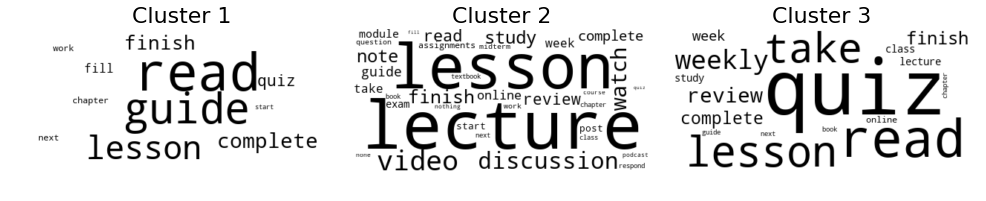

In [10]:
vectorizer_params = {"min_df": 5, "max_df": 500, "lowercase": True, "stop_words": STOPWORDS, "ngram_range": (1, 1)}
clustering_params = {"n_clusters": 3, "random_state": 3}
classifier_cact_kmeans, vectorizer_cact_kmeans = unsupervised_checking(preprocessed_cact, tf_idf = True, kMeans = True,
                                   vectorizer_params = vectorizer_params, clustering_params = clustering_params,nrow=1, ncol=3,
                                    fname = "../slides_dataviz/plots/KMeans_cact_3_clusters.eps")

Group 0-1
Size:   512
Group 0-2
Size:   177
Group 0-3
Size:   116


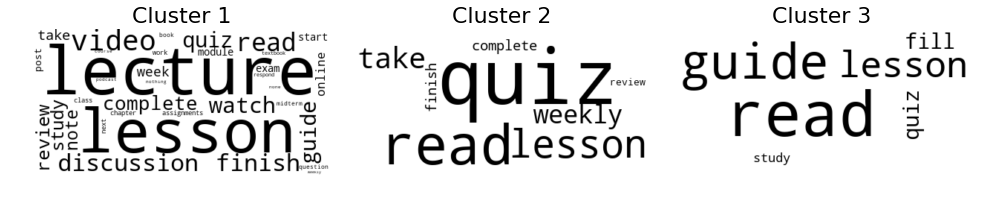

In [11]:
clustering_params = {"n_clusters": 3}
classifier_cact_agg, vectorizer_cact_agg = unsupervised_checking(preprocessed_cact, tf_idf = True, kMeans = False,
                                   vectorizer_params = vectorizer_params, clustering_params = clustering_params, nrow=1, ncol=3,
                                   fname = "../slides_dataviz/plots/AGG_cact_3_clusters.eps")

## Course-related activities could be categorized into "quiz", "guide", "lecture vedio" and "general materials"

## Save Vectorizer and Classifier

In [12]:
# obj = {
#     "oact": [vectorizer_oact_kmeans, classifier_oact_kmeans],
#     "cact": [vectorizer_cact_kmeans, classifier_cact_kmeans]
# }

# save_object(obj, os.path.join(DMOL_DIR, "data", "act_list_cluster.pkl"))